In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import *
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def my_dataset(mydir, Categories, input_shape):
    images = []
    labels = []
    
    for folder in os.listdir(mydir):
        folder_path = os.path.join(mydir, folder)
        
        if folder in Categories:
            label = Categories.index(folder)
        else:
            print(f"Warning: Folder '{folder}' not found in Categories. Skipping.")
            continue
        try:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Failed to load image '{image_path}'. Skipping.")
                    continue
                image = cv2.resize(image, (input_shape, input_shape))
                image = image/255.0  #normalizing the image while creating dataset
                images.append(image) 
                labels.append(label)
        
        except Exception as e:
            print(f"Error processing images in folder '{folder}': {e}")
            continue
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return images, labels

In [2]:
mytraindir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
mytestdir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
myvaldir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
categories = os.listdir(mytestdir) #['PNEUMONIA', 'NORMAL']
input_shape = 224

In [7]:
X_train , y_train = my_dataset(mytraindir, categories, input_shape)
X_test , y_test = my_dataset(mytestdir, categories, input_shape)

In [54]:
print(X_train.shape, X_test.shape)

(5216, 224, 224, 3) (624, 224, 224, 3)


In [8]:
base_model = VGG16(weights = 'imagenet', include_top = False , input_shape = (input_shape, input_shape, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return float(lr * 0.9)
    else:
        return float(lr * 0.8)
    
lr_callback = LearningRateScheduler(lr_scheduler)

#early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True,  
    verbose=1            
)

In [33]:
import keras_tuner as kt
def model_build(hp):
    model = Sequential()
    model.add(tf.keras.Input(shape=(224,224,3)))
    model.add(base_model)
    
    model.add(Flatten())
    
    for i in range(hp.Int('no of layer', min_value = 1, max_value = 10)):
        model.add(Dense(
            hp.Int('no of nodes' + str(i), min_value = 32, max_value = 128, step = 32),
            activation = 'relu'
        ))
        model.add(Dropout(hp.Choice('dropout', values = [0.1,0.2,0.3,0.4,0.5])))
    
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss= 'binary_crossentropy', optimizer= hp.Choice('optimizer', values =['adam', 'rmsprop', 'adagrad', 'nadam', 'adadelta']), metrics=['accuracy'])
    return model   

In [34]:
tuner = kt.Hyperband(
    model_build,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='/kaggle/working/',
    project_name='my_project1'
)
tuner.search( X_train, y_train, epochs = 5, validation_data = (X_val, y_val), callbacks=[lr_callback])

Reloading Tuner from /kaggle/working/my_project1/tuner0.json


In [13]:
tuner.get_best_hyperparameters()[0].values

{'no of layer': 6,
 'no of nodes0': 64,
 'dropout': 0.5,
 'optimizer': 'adam',
 'no of nodes1': 32,
 'no of nodes2': 64,
 'no of nodes3': 64,
 'no of nodes4': 96,
 'no of nodes5': 128,
 'no of nodes6': 128,
 'no of nodes7': 128,
 'no of nodes8': 64,
 'no of nodes9': 64,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 3,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0009'}

In [42]:
new_model = tuner.get_best_models(num_models = 1)[0]
History = new_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10,callbacks = [lr_callback])

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - accuracy: 0.7565 - loss: 0.3780 - val_accuracy: 0.7548 - val_loss: 3.2765 - learning_rate: 9.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.7206 - loss: 0.4619 - val_accuracy: 0.6250 - val_loss: 0.5301 - learning_rate: 8.1000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.7442 - loss: 0.3732 - val_accuracy: 0.8429 - val_loss: 0.8582 - learning_rate: 7.2900e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.7793 - loss: 0.3310 - val_accuracy: 0.8958 - val_loss: 0.4624 - learning_rate: 6.5610e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.7856 - loss: 0.3388 - val_accuracy: 0.8462 - val_loss: 0.5334 - learning_rate: 5.9049e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.7922 - loss: 0.3270 - val_accuracy: 0.8494 - val_loss: 0.6221 - learning_rate: 5.3144e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 15

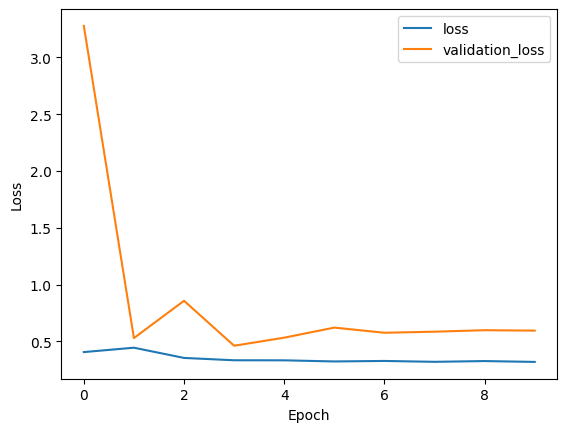

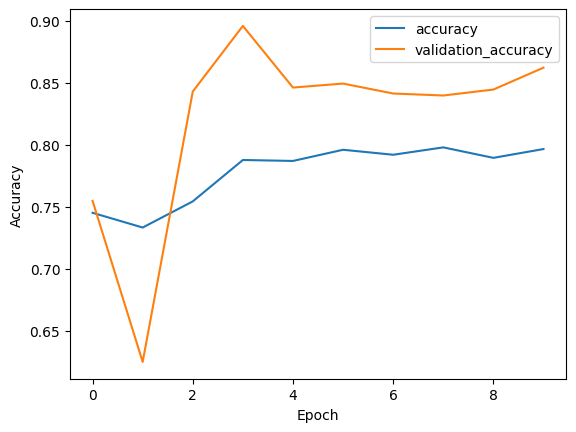

In [43]:
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eğitim ve Doğrulama Doğruluğu
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
loss, accuracy = new_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9494 - loss: 0.1908
Test Loss: 0.5953385233879089
Test Accuracy: 0.8621794581413269


In [51]:
from sklearn.metrics import mean_squared_error
y_pred_test = new_model.predict(X_test)
MSE_test = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error")
print("Testing Set: ", MSE_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step
Mean Squared Error
Testing Set:  0.1500523960083486


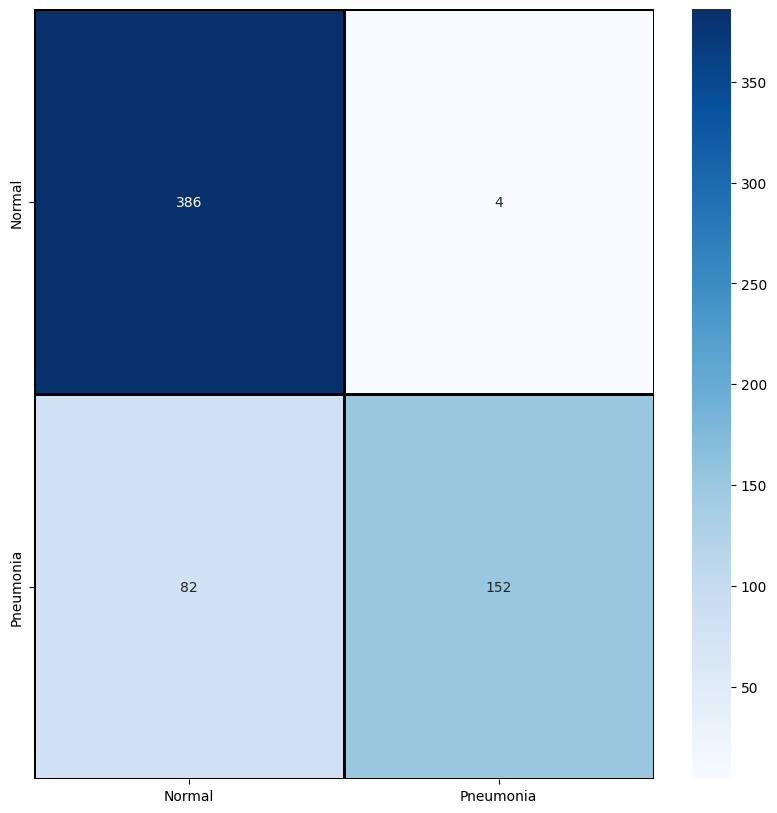

In [62]:
cm = pd.DataFrame(conf_matrix , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
labels = ['Normal', 'Pneumonia']
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.show()

My model performs well in terms of precision, meaning it makes very few false positive predictions. However, recall is lower, indicating that the model misses some positive instances. The F1 Score provides a balance between precision and recall.

where:
True Negatives (TN): 386 (normal cases correctly predicted as normal)
False Positives (FP): 4 (normal cases incorrectly predicted as cancer)
False Negatives (FN): 82 (cancer cases incorrectly predicted as normal)
True Positives (TP): 152 (cancer cases correctly predicted as cancer)

**NOW create our own cnn Network with Grayscale instead of BRG**

In [3]:

datagen = ImageDataGenerator(
    rescale=1./255,            
    rotation_range=10,         
    width_shift_range=0.1,     
    height_shift_range=0.1,    
    shear_range=0.1,           
    zoom_range=0.1,            
    horizontal_flip=True,      
    fill_mode='nearest'        
)


train_generator = datagen.flow_from_directory(
    mytraindir,           
    target_size=(224, 224),    
    color_mode='grayscale',    
    batch_size=32,             
    class_mode='binary'        
)


val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    myvaldir,      
    target_size=(224, 224),    
    color_mode='grayscale',    
    batch_size=32,             
    class_mode='binary'        
)


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    mytestdir,      
    target_size=(224, 224),    
    color_mode='grayscale',    
    batch_size=32,             
    class_mode='binary'        
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
#learning rate schedular
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return float(lr * 0.9)
    else:
        return float(lr * 0.8)
    
lr_callback = LearningRateScheduler(lr_scheduler)

#early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True,  
    verbose=1            
)

In [7]:
Model = Sequential()

Model.add(Conv2D(32, (3,3), padding = 'same', input_shape=((224, 224,1))))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))

Model.add(Conv2D(64, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))

Model.add(Conv2D(96, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

Model.add(Conv2D(128, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

Model.add(Conv2D(256, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))

Model.add(Conv2D(320, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))

Model.add(Conv2D(320, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))


Model.add(Flatten())

Model.add(Dense(256))
Model.add(Activation('relu'))

Model.add(Dense(64))
Model.add(Activation('relu'))

Model.add(Dense(32))
Model.add(Activation('relu'))

Model.add(Dense(1))
Model.add(Activation('sigmoid'))

Model.summary()

Model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 320)      │       737,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 7, 7, 320)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 320)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 320)      │       921,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 3, 3, 320)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 320)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 320)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 320)            │             

 Total params: 2,240,353 (8.55 MB)

 Trainable params: 2,240,353 (8.55 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
History = Model.fit(train_generator,epochs = 20,validation_data = test_generator, callbacks = [lr_callback, early_stopping ] )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726673131.859939     128 service.cc:145] XLA service 0x78baa4002750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726673131.860005     128 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726673131.860009     128 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/163 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7188 - loss: 0.6661 

I0000 00:00:1726673142.939671     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 522ms/step - accuracy: 0.7425 - loss: 0.5509 - val_accuracy: 0.6250 - val_loss: 0.5431 - learning_rate: 9.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 304ms/step - accuracy: 0.7979 - loss: 0.3690 - val_accuracy: 0.8510 - val_loss: 0.3679 - learning_rate: 8.1000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 303ms/step - accuracy: 0.8975 - loss: 0.2477 - val_accuracy: 0.8686 - val_loss: 0.3315 - learning_rate: 7.2900e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - accuracy: 0.9191 - loss: 0.2090 - val_accuracy: 0.8462 - val_loss: 0.3866 - learning_rate: 6.5610e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - accuracy: 0.9340 - loss: 0.1776 - val_accuracy: 0.7885 - val_loss: 0.5635 - learning_rate: 5.9049e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.9342 - loss: 0.1677 - val_accuracy: 0.9054 - val_loss: 0.2608 - learning_rate: 5.3144e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step -

In [9]:
# Evaluate the model on unseen validation data (test_generator)
loss, accuracy = Model.evaluate(validation_generator, verbose=1)
print(f"Test Loss Unseen data: {loss}")
print(f"Test Accuracy Unseen data: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9375 - loss: 0.2167
Test Loss Unseen data: 0.21671472489833832
Test Accuracy Unseen data: 0.9375


In [10]:
test_loss, test_accuracy = Model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9141 - loss: 0.2722
Test Loss: 0.26077979803085327
Test Accuracy: 0.9054487347602844
